In [71]:
# Basic packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics packages
from scipy.stats import norm, skew
from scipy.special import boxcox1p
import statsmodels.api as sm

# sklearn packages for model creation
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
import xgboost as xgb
import lightgbm as lgb

/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
# Import train and test data from .csv

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.shape

(1460, 81)

In [3]:
ids = test['Id']    # Submissions file requires an Id column

# Drop Id column from train and test set
train.drop(['Id'], inplace = True, axis = 1)
test.drop(['Id'], inplace = True, axis = 1)

train.head(10)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


In [4]:
# Check for missing values in train data

missing_data = train.isna().sum()
missing_data = missing_data.drop(missing_data[missing_data == 0].index)
missing_data

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [5]:
# Check for missing values in test data

missing_test = test.isna().sum()
missing_test = missing_test.drop(missing_test[missing_test == 0].index)
missing_test

MSZoning           4
LotFrontage      227
Alley           1352
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        16
MasVnrArea        15
BsmtQual          44
BsmtCond          45
BsmtExposure      44
BsmtFinType1      42
BsmtFinSF1         1
BsmtFinType2      42
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu      730
GarageType        76
GarageYrBlt       78
GarageFinish      78
GarageCars         1
GarageArea         1
GarageQual        78
GarageCond        78
PoolQC          1456
Fence           1169
MiscFeature     1408
SaleType           1
dtype: int64

## Correlation of features

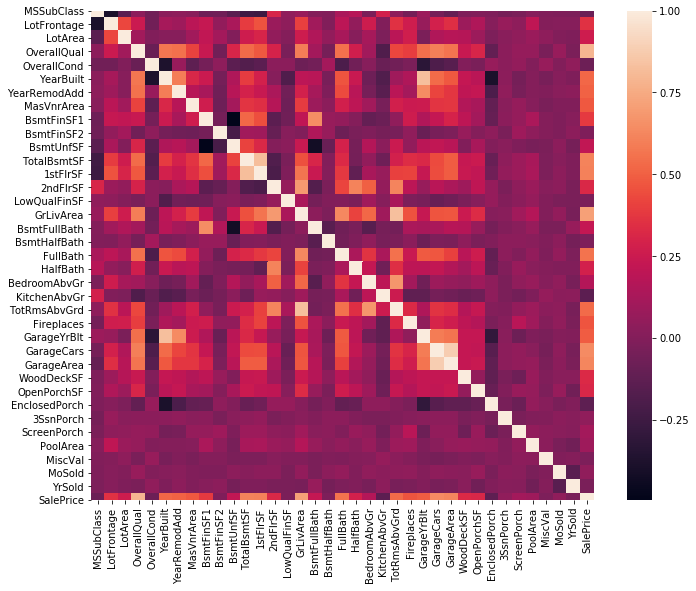

In [6]:
corr_matrix = train.corr()
f, ax = plt.subplots(figsize = (12,9))
sns.heatmap(corr_matrix, square = True)

#### Observations:

1. SalePrice is highly correlated with Overall Condition.
2. Area related features like TotalBsmtSF, !stFlrSF, GrLivArea, GarageCars, GarageArea have high impact on SalePrice.
3. GarageCars and GarageArea are highly correlated; greater the area, more the capacity.
4. GarageYrBuilt and YearBuilt, this could be because they were mostly built in the same year.
5. GrLivArea and TotRmsAbvGrd happen to be highly correlated too.

In [7]:
sales_corr = corr_matrix['SalePrice'].sort_values(ascending = False)
sales_corr.drop('SalePrice', axis = 0, inplace = True)
sales_corr.head(10)

OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64

#### Plotting  OverallQual and SalePrice

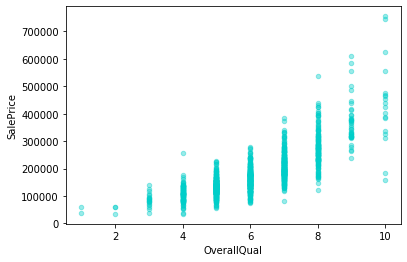

In [8]:
train.plot.scatter(x = 'OverallQual', y = 'SalePrice', alpha = 0.4, color = '#00cec9')

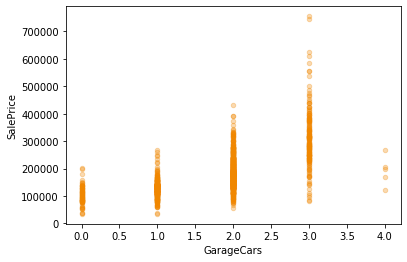

In [9]:
train.plot.scatter(x = 'GarageCars', y = 'SalePrice', alpha = 0.3, color = '#f08700')

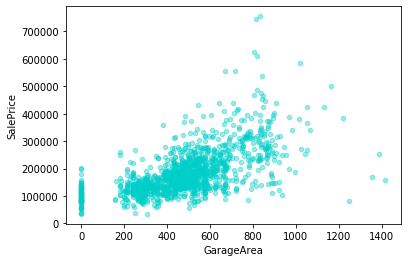

In [10]:
train.plot.scatter(x = 'GarageArea', y = 'SalePrice', alpha = 0.4, color = '#00cec9')

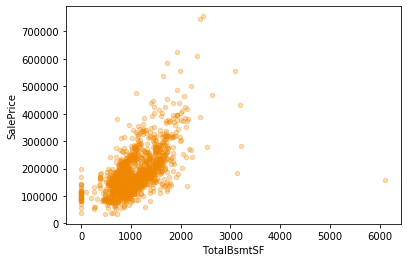

In [11]:
train.plot.scatter(x = 'TotalBsmtSF', y = 'SalePrice', alpha = 0.3, color = '#f08700')

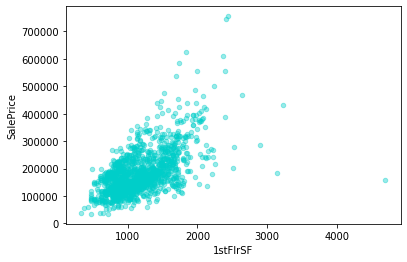

In [12]:
train.plot.scatter(x = '1stFlrSF', y = 'SalePrice', alpha = 0.4, color = '#00cec9')

## Outliers

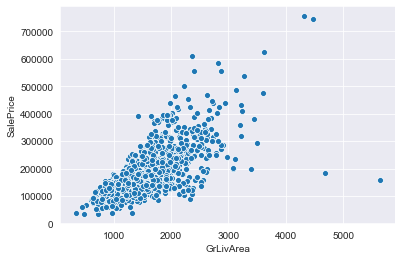

In [13]:
# Removal of outliers as stated in the Potential Pitfalls section, refer http://jse.amstat.org/v19n3/decock.pdf
# Houses with GRLIVAREA > 4000 sq ft will be removed - 4 outliers

sns.set_style('darkgrid')
ax = sns.scatterplot(x = train['GrLivArea'], y = train['SalePrice'])

train = train[train['GrLivArea'] < 4000]

## Dealing with missing data

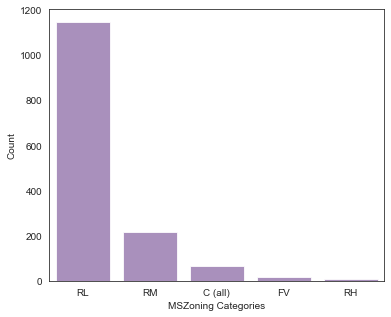

In [14]:
# MSZoning - Replacing NaNs with the commonly occuring value (RL)

sns.set_style('white')
plt.subplots(figsize = (6, 5))
sns.set_color_codes('muted')
ax = sns.barplot(x = train['MSZoning'].unique(), y = train.MSZoning.value_counts(), color = 'm', alpha = 0.8)
ax.set(xlabel = 'MSZoning Categories', ylabel = 'Count')

test.MSZoning = test.MSZoning.fillna('RL')

In [15]:
# LotFrontage 
# Houses in the same neighbourhood would probably have similar frontage areas; replace with median

train['LotFrontage'] = train.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
test['LotFrontage'] = test.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

In [16]:
# Alley - Replacing NaNs with 'None'

train['Alley'] = train['Alley'].fillna('None')
test["Alley"] = test['Alley'].fillna('None')
print(train.Alley.isna().sum())
print(test.Alley.isna().sum())

0
0


In [17]:
# Utilities 
# Dropping column since only 1 record in train set contains 'NoSeWa' with rest as 'AllPub'

print(train['Utilities'].value_counts())
train.drop(columns = ['Utilities'], inplace = True)
test.drop(columns = ['Utilities'], inplace = True)

AllPub    1455
NoSeWa       1
Name: Utilities, dtype: int64


In [18]:
# Exterior1st - Replacing with most common occurence

print(train.Exterior1st.mode())
test['Exterior1st'] = test.Exterior1st.fillna('VinylSd')
print(test.Exterior1st.isna().sum())

0    VinylSd
dtype: object
0


In [19]:
# Exterior2nd - Replacing with most common occurence

print(train.Exterior2nd.mode())
test['Exterior2nd'] = test.Exterior2nd.fillna('VinylSd')
print(test.Exterior2nd.isna().sum())

0    VinylSd
dtype: object
0


In [20]:
# MasVnrType - Replacing NaNs with 'None'

train['MasVnrType'] = train.MasVnrType.fillna('None')
test['MasVnrType'] = test.MasVnrType.fillna('None')

In [21]:
# MasVnrArea
# NaN values in this column all have MasVnrType as None - Hence replacing NaN with 0.0

train.MasVnrArea = train.MasVnrArea.fillna(0.0)
test.MasVnrArea = test.MasVnrArea.fillna(0.0)

In [22]:
# BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2

columns = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']

for col in columns:
    train[col] = train[col].fillna("None")
    test[col] = test[col].fillna("None")

In [23]:
# BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath, BsmtHalfBath

columns = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']

for col in columns:
    test[col] = test[col].fillna(0)

In [24]:
# Electrical - Replace Nan With the commonly occuring value

print(train.Electrical.mode())
train.Electrical = train.Electrical.fillna('SBrkr')

0    SBrkr
dtype: object


In [25]:
# KitchenQual - Replace Nan with commonly occuring value

print(train.KitchenQual.mode())
test.KitchenQual = test.KitchenQual.fillna('TA')

0    TA
dtype: object


In [26]:
# Functional - Assuming typical 'Typ'

test.Functional = test.Functional.fillna('Typ')

In [27]:
# FireplaceQu - NaN means no Fireplace "None"

train['FireplaceQu'] = train['FireplaceQu'].fillna('None')
test['FireplaceQu'] = test['FireplaceQu'].fillna('None')

In [28]:
# GarageType - NaN means no garage "None"

train['GarageType'] = train['GarageType'].fillna('None')
test['GarageType'] = test['GarageType'].fillna('None')

In [29]:
# GarageYrBlt - NaN means no garage, keep year as 0

train['GarageYrBlt'] = train['GarageYrBlt'].fillna(0)
test['GarageYrBlt'] = test['GarageYrBlt'].fillna(0)

In [30]:
# GarageFinish - NaN means no garage "None"

train['GarageFinish'] = train['GarageFinish'].fillna("None")
test['GarageFinish'] = test['GarageFinish'].fillna("None")

In [31]:
# GarageCars, GarageArea - NaN means no garage, replace with 0.0

test = test.fillna({'GarageCars':0.0, "GarageArea": 0.0})

In [32]:
# GarageQual, GarageCond - NaN means no garage "None"

for col in ['GarageQual','GarageCond']:
    train[col] = train[col].fillna("None")
    test[col] = test[col].fillna("None")

In [33]:
# PoolQC, Fence - NaN means no Pool/Fence, "None"

for col in ['PoolQC', 'Fence']:
    train[col] = train[col].fillna("None")
    test[col] = test[col].fillna("None")

In [34]:
# MiscFeature

train['MiscFeature'] = train['MiscFeature'].fillna('None')
test['MiscFeature'] = test['MiscFeature'].fillna('None')

In [35]:
# SaleType

print(train['SaleType'].mode())
test['SaleType'].fillna('WD', inplace = True)

0    WD
dtype: object


## Representing some categories with ordered numbers

In [36]:
# ExterQual, ExterCond, HeatingQC, KitchenQual

exter_map = {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1}
for col in ['ExterQual', 'ExterCond', 'HeatingQC', 'KitchenQual']:
    train[col] = train[col].map(exter_map).astype(int)
    test[col] = test[col].map(exter_map).astype(int)

In [37]:
# BsmtQual, BsmtCond, FireplaceQu, PoolQC

bsmt_map = {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "None": 0}

for col in ['BsmtQual', 'BsmtCond', 'FireplaceQu', 'GarageCond', 'GarageQual', 'PoolQC']:
    train[col] = train[col].map(bsmt_map).astype(int)
    test[col] = test[col].map(bsmt_map).astype(int)

In [38]:
# BsmtExposure

exp_map = {'Gd': 3, 'Av': 2, 'Mn': 1, 'No': 0, 'None': 0}
train['BsmtExposure'] = train['BsmtExposure'].map(exp_map).astype(int)
test['BsmtExposure'] = test['BsmtExposure'].map(exp_map).astype(int)

In [39]:
# BsmtFinType1, BsmtFinType2

fintype_map = {'GLQ': 6, "ALQ": 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'None': 0}
for col in ['BsmtFinType1', 'BsmtFinType2']:
    train[col] = train[col].map(fintype_map).astype(int)
    test[col] = test[col].map(fintype_map).astype(int)

In [40]:
# CentralAir (Necessary...?)

ca_map = {'Y': 1, 'N': 0}
train['CentralAir'] = train.CentralAir.map(ca_map)
test['CentralAir'] = test.CentralAir.map(ca_map)

In [41]:
# PavedDrive

pd_map = {'Y': 2, 'P': 1, 'N': 0}
train['PavedDrive'] = train.PavedDrive.map(pd_map)
test['PavedDrive'] = test.PavedDrive.map(pd_map)

In [42]:
# Fence

fence_map = {'GdPrv': 2, 'MnPrv': 1, 'GdWo': 2, 'MnWw': 1, 'None': 0}
train['Fence'] = train.Fence.map(fence_map)
test['Fence'] = test.Fence.map(fence_map)

In [43]:
# Street, Alley

street_map = {'Grvl': 2, 'Pave': 1, 'None': 0}
for col in ['Street', 'Alley']:
    train[col] = train[col].map(street_map)
    test[col] = test[col].map(street_map)

In [44]:
# LotShape

lot_map = {'Reg': 4, 'IR1': 3, 'IR2': 2, 'IR3': 1}
train['LotShape'] = train.LotShape.map(lot_map)
test['LotShape'] = test.LotShape.map(lot_map)

In [45]:
# LandSlope

slope_map = {'Gtl': 3, 'Mod': 2, 'Sev': 1}
train['LandSlope'] = train.LandSlope.map(slope_map)
test['LandSlope'] = test.LandSlope.map(slope_map)

In [46]:
# MasVnrType

mason_map = {'BrkCmn': 1, 'BrkFace': 1, 'CBlock': 1, 'Stone': 1, 'None': 0}
train['MasVnrType'] = train.MasVnrType.map(mason_map)
test['MasVnrType'] = test.MasVnrType.map(mason_map)

## Creating new features through modification of existing ones

In [47]:
# OverallQC - from OverallQual and OverallCond

train['OverallQC'] = (train['OverallQual'] + train['OverallCond']) / 2
test['OverallQC'] = (test['OverallQual'] + test['OverallCond']) / 2

train.drop(['OverallQual', 'OverallCond'], inplace = True, axis = 1)
test.drop(['OverallQual', 'OverallCond'], inplace = True, axis = 1)

In [48]:
# ExterQC - from ExterQual and ExterCond

train['ExterQC'] = (train['ExterQual'] + train['ExterCond']) / 2
test['ExterQC'] = (test['ExterQual'] + test['ExterCond']) / 2

train.drop(['ExterQual', 'ExterCond'], inplace = True, axis = 1)
test.drop(['ExterQual', 'ExterCond'], inplace = True, axis = 1)

In [49]:
# GarageQC - from GarageQual and GarageCond

train['GarageQC'] = (train['GarageQual'] + train['GarageCond']) / 2
test['GarageQC'] = (test['GarageQual'] + test['GarageCond']) / 2

train.drop(['GarageQual', 'GarageCond'], inplace = True, axis = 1)
test.drop(['GarageQual', 'GarageCond'], inplace = True, axis = 1)

In [50]:
# BsmtQC - from BsmtQual, BsmtCond, BsmtExposure

train['BsmtQC'] = (train['BsmtQual'] + train['BsmtCond'] + train['BsmtExposure']) / 3
test['BsmtQC'] = (test['BsmtQual'] + test['BsmtCond'] + test['BsmtExposure']) / 3

train.drop(['BsmtQual', 'BsmtCond', 'BsmtExposure'], axis = 1, inplace = True)
test.drop(['BsmtQual', 'BsmtCond', 'BsmtExposure'], axis = 1, inplace = True)

In [51]:
# TopFloorsArea - from 1stFlrSF, 2ndFlrSF
# TotalSFArea - from GrLivArea, TotalBsmtSF

train['TopFloorsArea'] = train['1stFlrSF'] + train['2ndFlrSF']  
train['TotalSFArea'] = train['GrLivArea'] + train['TotalBsmtSF']
test['TopFloorsArea'] = test['1stFlrSF'] + test['2ndFlrSF']  
test['TotalSFArea'] = test['GrLivArea'] + test['TotalBsmtSF']

train.drop(['1stFlrSF', '2ndFlrSF', 'GrLivArea', 'TotalBsmtSF'], inplace = True, axis = 1)
test.drop(['1stFlrSF', '2ndFlrSF', 'GrLivArea', 'TotalBsmtSF'], inplace = True, axis = 1)

In [52]:
# TotBaths - Total number of bathrooms from BsmtFullBath, BsmtHalfBath, HalfBath, FullBath.

train['TotBaths'] = train['BsmtFullBath'] + (0.5 * train['BsmtHalfBath']) + (0.5 * train['HalfBath']) + train['FullBath']
test['TotBaths'] = test['BsmtFullBath'] + (0.5 * test['BsmtHalfBath']) + (0.5 * test['HalfBath']) + test['FullBath']

train.drop(['BsmtFullBath', 'BsmtHalfBath', 'HalfBath', 'FullBath'], inplace = True, axis = 1)
test.drop(['BsmtFullBath', 'BsmtHalfBath', 'HalfBath', 'FullBath'], inplace = True, axis = 1)

In [53]:
# TotPorchSF - Total Square feet area of the porch.

train['TotPorchSF'] = train['OpenPorchSF'] + train['EnclosedPorch'] + train['3SsnPorch'] + train['ScreenPorch']
test['TotPorchSF'] = test['OpenPorchSF'] + test['EnclosedPorch'] + test['3SsnPorch'] + test['ScreenPorch']

train.drop(['OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch'], inplace = True, axis = 1)
test.drop(['OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch'], inplace = True, axis = 1)

The GarageCars and GarageYrBlt columns are dropped, as explained in the observations part of the feature correlation.

In [54]:
# Dropping the GarageCars, GarageYrBuilt columns.

train.drop(['GarageCars', 'GarageYrBlt'], inplace = True, axis = 1)
test.drop(['GarageCars', 'GarageYrBlt'], inplace = True, axis = 1)

## Tranforming highly skewed features

#### Seperating the numerical features from the categorical ones

In [55]:
# Converting the categorical features to Pandas Categorical type.
# This is done to distinguish them from the numerical features that are to be transformed.

columns = ['MSSubClass', 'MSZoning', 'LandContour', 'LotConfig', 
           'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
           'HouseStyle', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
           'RoofMatl', 'Exterior1st', 'Exterior2nd', 'Foundation', 
           'Heating', 'Electrical', 'Functional', 'GarageType', 
           'GarageFinish', 'PavedDrive', 'MiscFeature', 'MoSold', 
           'YrSold', 'SaleType', 'SaleCondition']

num_train = train.shape[0]
num_test = test.shape[0]

y_train = train['SalePrice'].values    # SalePrice 
train.drop(['SalePrice'], axis = 1, inplace = True)

all_data = pd.concat([train, test], axis = 0).reset_index(drop = True)

for col in columns:
    all_data[col] = pd.Categorical(all_data[col])

#### Checking the skewness levels

In [56]:
# Obtaining the column containing numerical features

num_features = all_data.dtypes[all_data.dtypes != 'category'].index
print(num_features)

Index(['LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandSlope',
       'MasVnrType', 'MasVnrArea', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'HeatingQC', 'CentralAir',
       'LowQualFinSF', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Fireplaces', 'FireplaceQu', 'GarageArea', 'WoodDeckSF',
       'PoolArea', 'PoolQC', 'Fence', 'MiscVal', 'OverallQC', 'ExterQC',
       'GarageQC', 'BsmtQC', 'TopFloorsArea', 'TotalSFArea', 'TotBaths',
       'TotPorchSF'],
      dtype='object')


In [57]:
# Skewness with magnitude 0.5 is considered to be moderate.
# A skewness magnitude greater than 1 is considered as high.

skewness = all_data[num_features].apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 0.5]
skewed_features = skewness.index

#### Performing log(1+x) transformation on highly skewed features

Log transformation works fine on both positively and negatively skewed data, another good transformation that can also be applied is the BoxCox transform.

In [58]:
all_data[skewed_features] = np.log1p(all_data[skewed_features])    

## One hot encoding categorical features

In [59]:
# Using the get_dummies() method from pandas to obtain dummy variables.

for col in columns:
    all_data = pd.concat([all_data, pd.get_dummies(all_data[col], prefix = col, drop_first = True)], axis = 1)

# Drop original columns

all_data.drop(columns, inplace = True, axis = 1)
print(all_data.shape)
all_data.head(5)

(2915, 392)


,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,MasVnrType,MasVnrArea,BsmtFinType1,BsmtFinSF1,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,4.189655,9.042040,0.693147,0.0,1.609438,1.386294,1,5.283204,6,6.561031,...,0,0,0,0,1,0,0,0,1,0
1,4.394449,9.169623,0.693147,0.0,1.609438,1.386294,0,0.000000,5,6.886532,...,0,0,0,0,1,0,0,0,1,0
2,4.234107,9.328212,0.693147,0.0,1.386294,1.386294,1,5.093750,6,6.188264,...,0,0,0,0,1,0,0,0,1,0
3,4.110874,9.164401,0.693147,0.0,1.386294,1.386294,0,0.000000,5,5.379897,...,0,0,0,0,1,0,0,0,0,0
4,4.442651,9.565284,0.693147,0.0,1.386294,1.386294,1,5.860786,6,6.486161,...,0,0,0,0,1,0,0,0,1,0


All the preprocessing steps have been successfully completed, now getting ready to obtain the initial split of the X_train and X_test data below.

In [60]:
X_train = all_data[:num_train]
X_test = all_data[num_train:]

## Feature scaling

In [61]:
scaler = StandardScaler()
X_train.loc[:, num_features] = scaler.fit_transform(X_train.loc[:, num_features])
X_test.loc[:, num_features] = scaler.transform(X_test.loc[:, num_features])

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


## Target variable: SalePrice

#### Checking the skewness of the target variable

The below plot shows that the distribution is right skewed or positively skewed.

Skewness:  1.564345548419458


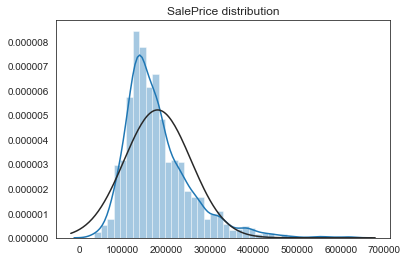

In [62]:
ax = sns.distplot(y_train, fit = norm)
ax.set_title('SalePrice distribution')
print("Skewness: ", skew(y_train))

#### Obtain the QQ Plot 

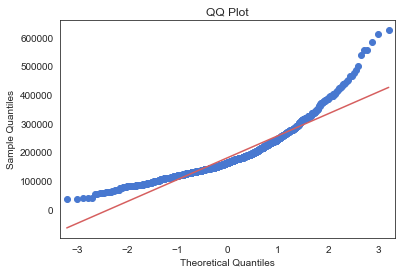

In [63]:
sm.qqplot(y_train, line = 's')
plt.title('QQ Plot')
plt.show()

#### Fixing the skew with log transformation

The right skew is fixed after log transformation of the target variable with numpy's log1p() function which is basically log(1+x). Log(1+x) is preferred because of the evaluation metric - it is the same as rmse with weights.
And also logarithm of 0 is undefined, so using np.log() could screw things.

In [64]:
y_train = np.log1p(y_train)

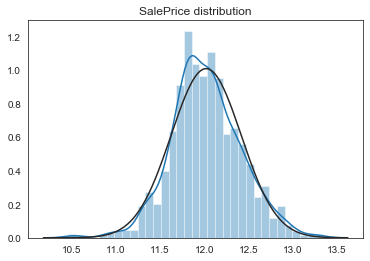

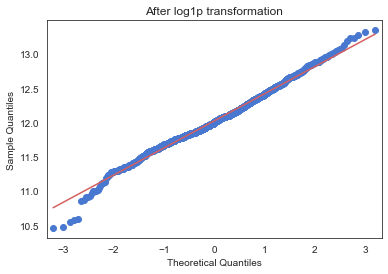

In [65]:
# Plotting the distribution and QQ plot

ax = sns.distplot(y_train, fit = norm)
ax.set_title('SalePrice distribution')

sm.qqplot(y_train, line = 's')
plt.title('After log1p transformation')
plt.show()

## Model Building 

In [66]:
rmse_scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring = rmse_scorer, cv = 10))
    return (rmse)

#### Ridge Regression

In [67]:
ridge = RidgeCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1.0, 3, 6, 10, 30, 60])
ridge.fit(X_train, y_train)

alpha = ridge.alpha_
print("Estimated alpha value: ",alpha)

# Phase 2 - Ridge

ridge = RidgeCV(alphas = [alpha * 0.5, alpha * 0.6, alpha * 0.7, alpha * 0.8, alpha * 0.9, alpha * 1,
                         alpha * 1.1, alpha * 1.2, alpha * 1.3, alpha * 1.4, alpha * 1.5])
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Estimated alpha value (Phase 2):", alpha)
print()
score = rmse_cv(ridge)
print("Mean Ridge Score:", score.mean())
print("Std. Deviation:", score.std())

Estimated alpha value:  30.0
Estimated alpha value (Phase 2): 18.0

Mean Ridge Score: 0.11729896380980867
Std. Deviation: 0.014773445787041557


#### Lasso Regression

In [68]:
lasso = LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 
                          0.01, 0.06, 0.1, 0.3, 0.6, 1], random_state = 0, cv = 10, max_iter = 50000)
lasso.fit(X_train, y_train)

alpha = lasso.alpha_
print("Estimated alpha value: ", alpha)

# Phase 2 - Lasso

lasso = LassoCV(alphas = [alpha * 0.5, alpha * 0.6, alpha * 0.7, alpha * 0.8, alpha * 0.9, alpha * 1,
                         alpha * 1.1, alpha * 1.2, alpha * 1.3, alpha * 1.4, alpha * 1.5], random_state = 0, 
                         max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Estimated alpha value (Phase 2):", alpha)
print()
score = rmse_cv(lasso)
print("Mean Lasso Score:", score.mean())
print("Std. Deviation:", score.std())

Estimated alpha value:  0.0006
Estimated alpha value (Phase 2): 0.00054

Mean Lasso Score: 0.11618151497890772
Std. Deviation: 0.015587898314495183


#### ElasticNet Regression

In [70]:
enet = ElasticNetCV(l1_ratio = [0.1, 0.15, 0.3, 0.55, 0.7, 0.95, 1],
                         alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 
                                   0.006, 0.1, 0.3, 0.6, 0.9, 1, 3, 6, 12],
                   max_iter = 50000, cv = 10)
enet.fit(X_train, y_train)
ratio = enet.l1_ratio_
alpha = enet.alpha_
print("Best l1 ratio:", ratio)
print("Best alpha:", alpha)

# Phase 2 - ElasticNet

enet = ElasticNetCV(l1_ratio = ratio,
                   alphas = [alpha * 0.5, alpha * 0.6, alpha * 0.7, alpha * 0.8, alpha * 0.9, alpha * 1,
                         alpha * 1.1, alpha * 1.2, alpha * 1.3, alpha * 1.4, alpha * 1.5], random_state = 0, 
                         max_iter = 50000, cv = 10)
enet.fit(X_train, y_train)
ratio = enet.l1_ratio_
alpha = enet.alpha_
print("Best l1 ratio (Phase 2):", ratio)
print("Best alpha (Phase 2):", alpha)
print()
score = rmse_cv(enet)
print("Mean ElasticNet score:", score.mean())
print("Std. Deviation:", score.std())

Best l1 ratio: 0.15
Best alpha: 0.003
Best l1 ratio (Phase 2): 0.15
Best alpha (Phase 2): 0.0027

Mean ElasticNet score: 0.11596284844918181
Std. Deviation: 0.015316092121655467


In [ ]:
y_pred = np.expm1(enet.predict(X_test))
y_pred 

In [ ]:
# Creating the submissions .csv file

submissions = pd.DataFrame({
    
    'Id': ids,
    'SalePrice': y_pred
})

submissions.to_csv('submission3.csv', index = False)